In [1]:
#instal libraries

#pip install sentence-transformers
#pip install umap-learn
#pip install hdbscan

In [1]:
#import libraries

import re
from sentence_transformers import SentenceTransformer
import umap
import hdbscan
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
#reads in california constitution

#i need to clean the data more

with open('../DATA/2007.txt', 'r') as f:
    data = f.read()

In [3]:
data

'When the boy was born...\n\n\n  \n... like all Spartans, he was inspected.\n\n\n  \nIf he\'d been small or puny\nor sickly or misshapen...\n\n\n  \n... he would have been discarded.\n\n\n  \nFrom the time he could stand,\nhe was baptized in the fire of combat.\n\n\n  \nTaught never to retreat,\nnever to surrender.\n\n\n  \nTaught that death on the battlefield\nin service to Sparta...\n\n\n  \n... was the greatest glory\nhe could achieve in his life.\n\n\n  \nAt age 7, as is customary in Sparta...\n\n\n  \n... the boy was taken from his mother\nand plunged into a world of violence.\n\n\n  \nManufactured by 300 years\nof Spartan warrior society...\n\n\n  \n... to create the finest soldiers\nthe world has ever known.\n\n\n  \nThe agoge, as it\'s called,\nforces the boy to fight.\n\n\n  \nStarves them, forces them to steal...\n\n\n  \n... and if necessary, to kill.\n\n\n  \nBy rod and lash the boy was punished...\n\n\n  \n... taught to show no pain, no mercy.\n\n\n  \nConstantly tested, t

In [4]:
#data cleaning

def clean(text):
    pattern = r"\b(?=[MDCLXVIΙ])M{0,4}(CM|CD|D?C{0,3})(XC|XL|L?X{0,3})([IΙ]X|[IΙ]V|V?[IΙ]{0,3})\b\.?"
    return re.sub(pattern, ' ', text)

data = clean(data)
data = data.replace('SEC.', ' ')

In [5]:
#Removes all numbers
data = ''.join([i for i in data if not i.isdigit()])

In [6]:
data = data.split("\n")    

In [7]:
data = [item for item in data if item != '']

In [8]:
data

['When the boy was born...',
 '  ',
 '... like all Spartans, he was inspected.',
 '  ',
 " If he'd been small or puny",
 'or sickly or misshapen...',
 '  ',
 '... he would have been discarded.',
 '  ',
 'From the time he could stand,',
 'he was baptized in the fire of combat.',
 '  ',
 'Taught never to retreat,',
 'never to surrender.',
 '  ',
 'Taught that death on the battlefield',
 'in service to Sparta...',
 '  ',
 '... was the greatest glory',
 'he could achieve in his life.',
 '  ',
 'At age , as is customary in Sparta...',
 '  ',
 '... the boy was taken from his mother',
 'and plunged into a world of violence.',
 '  ',
 ' Manufactured by  years',
 'of Spartan warrior society...',
 '  ',
 '... to create the finest soldiers',
 'the world has ever known.',
 '  ',
 "The agoge, as it's called,",
 'forces the boy to fight.',
 '  ',
 'Starves them, forces them to steal...',
 '  ',
 '... and if necessary, to kill.',
 '  ',
 'By rod and lash the boy was punished...',
 '  ',
 '... taught 

In [9]:
model = SentenceTransformer('distilbert-base-nli-mean-tokens')
embeddings = model.encode(data, show_progress_bar = True)

Batches:   0%|          | 0/936 [00:00<?, ?it/s]

In [10]:
umap_embeddings = umap.UMAP(n_neighbors=15, n_components=2, metric='cosine').fit_transform(embeddings)

In [11]:
cluster = hdbscan.HDBSCAN(min_cluster_size=15,
                          metric='euclidean', 
                          cluster_selection_method='eom').fit(umap_embeddings)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Avoid using `tokenizers` before the fork if possible
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
	- Avoid using `tokenizers` before the fork if possible
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
huggingface/tokenizers: The 

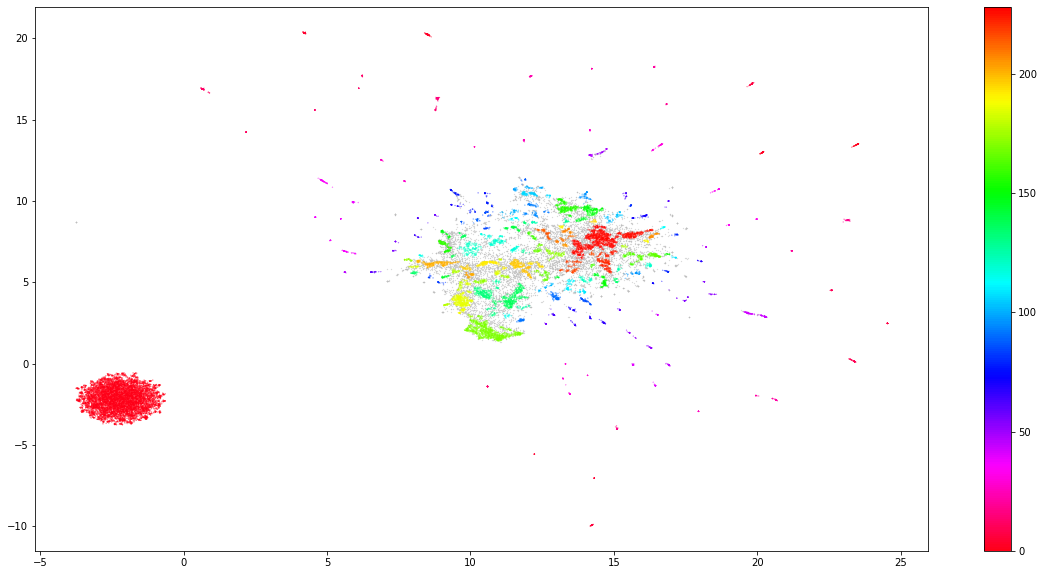

In [12]:
#umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_embeddings, columns=['x','y'])
result['labels'] = cluster.labels_

fig, ax = plt.subplots(figsize=(20,10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]

plt.scatter(outliers.x, outliers.y, color = '#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()

In [13]:
docs_df = pd.DataFrame(data, columns=["Doc"])
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

In [14]:
docs_per_topic

,Topic,Doc
0,-1,If he'd been small or puny ... he would have ...
1,0,...
2,1,"- "" Designer"" ARTIE ..."
3,2,Peru -- Colombia -- ...
4,3,SHREK THE THIRD SHRE...
...,...,...
225,224,That's it. ...but me. am the emissary... You...
226,225,What is it? -What's happening? What was that? ...
227,226,"Now, what message do you bring? ...what do you..."
228,227,the world has ever known. It was his initiati...


In [15]:
def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count

In [16]:
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(data))

/var/folders/sx/mxg316554p53ftfz37jrsvnr0000gn/T/ipykernel_10356/3267578824.py:5: RuntimeWarning: invalid value encountered in true_divide
  tf = np.divide(t.T, w)


In [17]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names_out()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(15)

,Topic,Size
1,0,8181
0,-1,7605
228,227,1254
171,170,1165
138,137,463
187,186,456
133,132,277
227,226,275
202,201,249
150,149,246


In [18]:
len(top_n_words)

230

In [19]:
index = [0,227,170,137,186,132,226,201,149,156]

In [20]:
for i in index:
    print("Topic #", i-1)
    print(top_n_words[i][:7])
    print()

Topic # -1
[('barrage', 4.806901738706837), ('controls', 4.002182782489787), ('édouard', 0.0), ('flock', 0.0), ('floods', 0.0), ('flooding', 0.0), ('flooded', 0.0)]

Topic # 226
[('come', 0.14844481645811947), ('got', 0.09963453156267638), ('ll', 0.09615291402515272), ('want', 0.0923138670744927), ('need', 0.08774770649723188), ('just', 0.086522602198671), ('ve', 0.07795539945078607)]

Topic # 169
[('don', 0.36984683324653844), ('know', 0.1293600395762125), ('doesn', 0.11962396543165961), ('didn', 0.11528910987150841), ('wasn', 0.065025980843371), ('think', 0.05399737610680082), ('isn', 0.053524316194901875)]

Topic # 136
[('stop', 0.2787942263115709), ('let', 0.233135596507701), ('away', 0.19976094490323265), ('leave', 0.09545886207491751), ('just', 0.08299533134199223), ('far', 0.07989896702002267), ('shut', 0.0738341128448481)]

Topic # 185
[('bad', 0.08602816176547994), ('weird', 0.06928975991503009), ('hard', 0.057581292828572536), ('traitor', 0.0566855943051737), ('little', 0.056